In [4]:
%matplotlib inline

# TAREA 2

**Adapted from:** [Nathan Inkawhich](https://github.com/inkawhich)

In this task, we will look at how to create a model for image classification, the impact of transfer learning using models pretrained on the 1000-class Imagenet dataset. The most efficient parameters for each architectures are likely to change, so you must look at the existing architecture and make custom adjustments for each model.

We will try to learn using a model **trained from scratch**, to do **feature extraction** by using only the last layer of a pre-trained network and only update the final layer weights using our data and label (i.e., using the CNN as a fixed feature extractor), and to **fine-tune** a pretrained model and update *all* of the model’s parameters for our task.

More information about transfer learning [in the CS231n class of Standford](https://cs231n.github.io/transfer-learning/) and in [Sebastian Ruder's blog post](https://ruder.io/transfer-learning/).

### Goal

The goals for you are to
* Fill up the code at different points where you have `# TODO`,
* Try different hyper-parameters of the models, different training and evaluation settings in order to answer the questions
* In the end you will have to upload an image of yours to test your model on it!    

### Data

We will use an Emotion Recognition dataset derived from FlickR30k. It is available at [this link](https://www.dcc.uchile.cl/~vbarrier/Flicker_data). It is composed of images that have been automatically tagged with several different emotions: `amusement, anger, awe, contentment, disgust, excitement, fear, sadness`.

Download the data and set them in your google drive. The ``model_name`` input is the name of the model you wish to use and must
be selected from this list:
```python
['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet']
```

In [9]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import shutil
#from google.colab import files, drive
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score
import pandas as pd
import seaborn as sn
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

INIT_PATH = '/content/drive/My Drive/'
print('INIT_PATH : {}'.format(INIT_PATH))

PyTorch Version:  2.4.1+cu124
Torchvision Version:  0.19.1+cpu
INIT_PATH : /content/drive/My Drive/


### Inputs
   
The other inputs are as follows:
* ``num_classes`` is the number of classes in the dataset, which is 8 in our case
* ``batch_size`` is the batch size used for training and may be adjusted according to the capability of your machine, ``num_epochs`` is the number of training epochs we want to run,
* ``feature_extract`` is a boolean that defines if we are finetuning or feature extracting. If ``feature_extract = False``, the model is finetuned and all model parameters are updated. If ``feature_extract = True``, only the last layer parameters are updated, the others remain fixed
* `lr` which is the learning rate of the optimizer

In [10]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./Flicker_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size = 128

# Number of epochs to train for
num_epochs = 25

# learning rate of the optimizer
lr=0.01

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Flag for data augmentation. When True apply a random cropped, a random
#   flip on the training images, and a rotation.
data_augmentation = True

# if we want to top-N results;
#   set an integer if want the top-3 results for example, set None if not wanted
topNresults = 3

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
[here](https://pytorch.org/docs/master/torchvision/models.html).


Two options to load the data:
* Option 1: Download the dataset, and put it directly in your Google Drive that you can access through colab. **This is better as you do not need to download the data everytime you are intiating a new colab instance. You will also be able to save your best model!**
* Option 2: Download the dataset directly on the colab instance

#### Option 1: Use the dataset already in my Google Drive

Here I am using as path of the project `'/content/drive/My Drive/DATASETS/deepemotion/'` where I should put the [dataset](https://users.dcc.uchile.cl/~vbarrier/Flicker_data/) `Flicker_data`. It means that I have it in my google drive under the path `'DATASETS/deepemotion/'`

In [ ]:
if not os.path.isdir('/content/drive'):
  drive.mount('/content/drive')

path_corpus = '/content/drive/My Drive/DATASETS/deepemotion/'
if data_dir[0] != "/":
  data_dir = os.path.join(path_corpus, data_dir)

#### Option 2: Download the data directly here

In [8]:
# download data, it generates temp.zip file
! wget https://users.dcc.uchile.cl/~vbarrier/Flicker_data/Flicker_data.zip -O temp.zip

# unzip data, it generates Flicker_data folder
! unzip /content/temp.zip

data_dir = "/content/Flicker_data"

--2024-09-19 12:31:51--  https://users.dcc.uchile.cl/~vbarrier/Flicker_data/Flicker_data.zip
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2671405035 (2.5G) [application/zip]
Saving to: ‘temp.zip’

temp.zip            100%[===================>]   2.49G  6.87MB/s    in 6m 55s  

2024-09-19 12:38:47 (6.14 MB/s) - ‘temp.zip’ saved [2671405035/2671405035]

Archive:  /content/temp.zip
replace Flicker_data/fine_tune_total_best_accuracy.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

**Model Training and Validation Code**

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.


In [11]:
def update_lists_for_f1_score(preds, labels, target_true, predicted_true, correct_true, all_labels):
  """
  Need to be executed at every batch in order to update the lists target_true, predicted_true and correct_true.
  target = TP + FN
  predicted_true = TP + FP
  correct_true = TP
  """
  # iterating over all the classes
  for class_k in all_labels:
    predicted_classes = preds == class_k
    target_classes = labels == class_k
    target_true[class_k] += torch.sum(target_classes).float()
    predicted_true[class_k] += torch.sum(predicted_classes).float()
    correct_true[class_k] += torch.sum(
        (predicted_classes) * (target_classes)).float()
  return target_true, predicted_true, correct_true

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                   use_tqdm=False, name_model = 'best_model_no_feature_extraction.pt'):
    since = time.time()
    t0 = since

    if topNresults: print('Top-{:d} results counted as good prediction'.format(topNresults))

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to initialize the counters of the true
    dico_labels = image_datasets['val'].class_to_idx
    dico_labels_inverse = {v:k for k, v in dico_labels.items()}
    all_labels = dico_labels.values()
    dict_true_init = {idx_lab : 0 for idx_lab in all_labels}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # Set model to training/evaluate mode
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            target_true = dict_true_init.copy()
            predicted_true = dict_true_init.copy()
            correct_true = dict_true_init.copy()

            # Iterate over data.
            array_for_loop = dataloaders[phase]
            if use_tqdm or (epoch == 0): # training is slow at 1st epoch
              array_for_loop = tqdm(array_for_loop)
            for inputs, labels in array_for_loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # TODO
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # TODO
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # create predictions
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    # TODO
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                target_true, predicted_true, correct_true = update_lists_for_f1_score(preds, labels.data,
                                                    target_true, predicted_true, correct_true, all_labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # calculating F1
            recall = []
            precision = []
            f1_score = []
            # At the end of the epoch
            for k_class in range(len(set(all_labels))):
                recall.append(correct_true[k_class] / target_true[k_class])
                precision.append(correct_true[k_class] / predicted_true[k_class])
                f1_score.append(2 * precision[k_class] * recall[k_class] / (precision[k_class] + recall[k_class]))

            epoch_f1 = np.mean([k.cpu().numpy() for k in f1_score])

            time_epoch = time.time()-t0
            print('{} Loss: {:.4f} Acc: {:.4f}  F1: {:.4f} in {:.0f}m {:.0f}s'.format(phase, epoch_loss, epoch_acc,
                                                                          epoch_f1, time_epoch // 60, time_epoch % 60))
            # write the F1 per label
            # if phase == 'val':
            if True:
                str_to_write = 'F1 : '
                for k, v in dico_labels.items():
                    str_to_write += "'{}' : {:.4f}, ".format(k, f1_score[v])
                print(str_to_write)

            t0 = time.time()

            # deep copy the model if best accuracy in this epoch
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                print('Best model saved')
                torch.save(model, 'temp_' + name_model)
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

#### Set Model Parameters’ .requires_grad attribute

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Initialize and Reshape the Networks


Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

### Resnet

Resnet was introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385). There are several variants of different sizes, including Resnet18, Resnet34, Resnet50, Resnet101, and Resnet152, all of which are available from torchvision models. Here we use Resnet18, as our dataset is small and only has two classes. When we print the model, we see that the last layer is a fully connected layer as shown below:

```
   (fc): Linear(in_features=512, out_features=1000, bias=True)
```

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

```
   model.fc = nn.Linear(512, num_classes)
```

### Alexnet


Alexnet was introduced in the paper [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) and was the first very successful CNN on the ImageNet dataset. When we print the model architecture, we see the model output comes from the 6th layer of the classifier

```

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
```
To use the model with our dataset we reinitialize this layer as

```
   model.classifier[6] = nn.Linear(4096,num_classes)
```

### VGG

VGG was introduced in the paper [Very Deep Convolutional Networks for
Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf). Torchvision offers eight versions of VGG with various lengths and some that have batch normalizations layers. Here we use VGG-11 with batch normalization. The output layer is similar to Alexnet, i.e.

```

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
```
Therefore, we use the same technique to modify the output layer

```

   model.classifier[6] = nn.Linear(4096,num_classes)
```

### Squeezenet


The Squeeznet architecture is described in the paper [SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size](https://arxiv.org/abs/1602.07360) and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

```

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    )
```

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

```

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
```

### Densenet

Densenet was introduced in the paper [Densely Connected Convolutional
Networks](https://arxiv.org/abs/1608.06993). Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

```
   (classifier): Linear(in_features=1024, out_features=1000, bias=True)

```

To reshape the network, we reinitialize the classifier’s linear layer as

```
   model.classifier = nn.Linear(1024, num_classes)
```

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "resnet50":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224


    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\Daniel\Desktop\Deep Learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Creation Datasets and Dataloaders

Regarding Data Augmentation, use `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip`, and also `transforms.RandomRotation` to see which one works best

In [14]:
def return_datasets_dataloaders(data_dir, input_size=224, angle_rotation=5, data_augmentation = True):
    """
    Create the datasets and dataloaders needed for the training
    """

    # apply data augmentation
    list_data_transform_data_aug = [
            # TODO
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(angle_rotation),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    # test without data_augmentation
    list_data_transform = [
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]

    # Data augmentation and normalization for training
    # Just normalization for validation
    if data_augmentation:
        data_transforms = {
            'train': transforms.Compose(list_data_transform_data_aug),
            'val': transforms.Compose(list_data_transform),
        }
    else: # no data augmentation in this case
        data_transforms = {
            'train': transforms.Compose(list_data_transform),
            'val': transforms.Compose(list_data_transform),
        }


    print("Initializing Datasets and Dataloaders"+data_augmentation*" with data augmentation"+"...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    return image_datasets, dataloaders_dict

image_datasets, dataloaders_dict = return_datasets_dataloaders(data_dir, data_augmentation = data_augmentation)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders with data augmentation...


Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [15]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=lr, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [16]:
name_model = 'best_model_'+'no_'*(not feature_extract)+'feature_extraction'+(data_augmentation)*'_data_augmentation'+'.pt'

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,
                             use_tqdm=False, name_model = name_model)

torch.save(model_ft, '{}/{}'.format(data_dir, name_model))
os.remove('temp_' + name_model)

Top-10 results counted as good prediction
Epoch 0/24
----------


100%|██████████| 168/168 [01:01<00:00,  2.75it/s]


train Loss: 1.3300 Acc: 0.5226  F1: 0.4400 in 1m 1s
F1 : 'amusement' : 0.6618, 'anger' : 0.1774, 'awe' : 0.5792, 'contentment' : 0.5491, 'disgust' : 0.5349, 'excitement' : 0.4235, 'fear' : 0.1561, 'sadness' : 0.4383, 


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


val Loss: 1.5390 Acc: 0.4783  F1: 0.4475 in 0m 5s
F1 : 'amusement' : 0.6119, 'anger' : 0.0690, 'awe' : 0.6804, 'contentment' : 0.4321, 'disgust' : 0.5610, 'excitement' : 0.4359, 'fear' : 0.3158, 'sadness' : 0.4737, 
Best model saved

Epoch 1/24
----------
train Loss: 1.2019 Acc: 0.5704  F1: 0.5003 in 1m 1s
F1 : 'amusement' : 0.7131, 'anger' : 0.2652, 'awe' : 0.6162, 'contentment' : 0.5833, 'disgust' : 0.5784, 'excitement' : 0.4948, 'fear' : 0.2519, 'sadness' : 0.4996, 
val Loss: 1.2901 Acc: 0.5192  F1: 0.5094 in 0m 5s
F1 : 'amusement' : 0.6809, 'anger' : 0.2933, 'awe' : 0.6596, 'contentment' : 0.4882, 'disgust' : 0.5600, 'excitement' : 0.5614, 'fear' : 0.3514, 'sadness' : 0.4808, 
Best model saved

Epoch 2/24
----------
train Loss: 1.1112 Acc: 0.6046  F1: 0.5413 in 0m 58s
F1 : 'amusement' : 0.7370, 'anger' : 0.3268, 'awe' : 0.6496, 'contentment' : 0.6167, 'disgust' : 0.6268, 'excitement' : 0.5337, 'fear' : 0.3073, 'sadness' : 0.5325, 
val Loss: 1.2024 Acc: 0.5627  F1: 0.5468 in 0m 5s
F

#### Plot hist

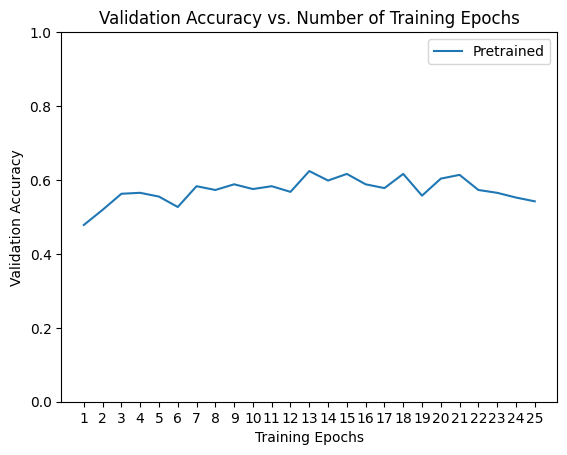

In [17]:
def plot_hist(hist):
  """
  Plot the training curves of validation accuracy vs. number of training epochs
  """
  ohist = []

  ohist = [h.cpu().numpy() for h in hist]

  plt.title("Validation Accuracy vs. Number of Training Epochs")
  plt.xlabel("Training Epochs")
  plt.ylabel("Validation Accuracy")
  plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
  # plt.plot(range(1,num_epochs+1),shist,label="Scratch")
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend()
  plt.show()

plot_hist(hist)

### Some visualizations

We keep one model under the name `'fine_tune_total_best_accuracy.pt'` that obtained the scores below so that we can check it's F1 score.

Let's have a look at the model's predictions with
* the confusion matrix to see between which class is the confusion
* the top-N predictions to see if the model predict in which position it predicts the right class. It is important as emotion can be multi-class and are subjectives
* A aggregation of the emotions regarding their valence (positiveness)

In [18]:
def calc_preds_with_topN(outputs, y_true, N=3):
    """
    Put the prediction as the GT if the GT is in the top-N predictions of the model
    """

    preds_sorted = torch.argsort(outputs, dim = 1, descending = True)

    # bool_preds is true if the prediction is in the top-N
    bool_preds = preds_sorted[:,0] == y_true
    for i in range(1, N):
      bool_preds += preds_sorted[:,i] == y_true

    y_hat = (~bool_preds)*preds_sorted[:,0] + bool_preds*y_true

    return y_hat

def return_y(model, dataloaders, phase='val', topNresults=None):
    """
    TODO
    Function to return the predicted and true labels from the model during inference.

    Args:
    model: The trained model to be evaluated.
    dataloaders: A dictionary containing data loaders for different phases (e.g., 'train', 'val', 'test').
    phase: The phase to be used for evaluation (default is 'val').
    topNresults: If provided, the function will return top N predictions, otherwise, it returns the highest prediction.

    Returns:
    y_hat: A list of predicted labels.
    y_true: A list of true labels.
    """

    y_hat = []  # Initialize an empty list to store predicted labels.
    y_true = []  # Initialize an empty list to store true labels.

    # Iterate over the batches of data in the specified phase (e.g., 'val').
    for inputs, labels in dataloaders[phase]:
        # Move the input and label data to the specified device (e.g., GPU).
        # TODO
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Disable gradient calculation during inference to save memory and computation (with loop)
        # Perform a forward pass through the model to get the outputs.
        # If topNresults is specified, calculate predictions using (or not) top N probabilities using the outputs
        # (regarding the value of the boolean variable topNresults)
        # TODO
        with torch.no_grad():
            outputs = model(inputs)
            if topNresults:
                preds = calc_preds_with_topN(outputs, labels, N=topNresults)
            else:
                _, preds = torch.max(outputs, 1)

        # Append the predictions and the true labels to their respective lists after moving them to the CPU.
        for pred, label in zip(preds, labels):
            y_hat.append(pred.cpu())
            y_true.append(label.cpu())

    # Return the lists of predicted and true labels.
    return y_hat, y_true


def print_conf_mat_topN(model, dataloaders, all_labels_names, show_print=False,
                        phase = 'val', topNresults=None, binary_classif = False,
                       positive_classes = [0, 2, 3, 5]):
    """
    Allow to directly print the confusion matrix with the top-N prediction.
    Also print the associated F1.
    The classes [0, 2, 3, 5] are the positive emotions
    """

    y_hat, y_true = return_y(model, dataloaders, phase = 'val', topNresults=None)

    if binary_classif:
        y_hat = [k in positive_classes for k in y_hat]
        y_true = [k in positive_classes for k in y_true]
        all_labels_names = ['negative', 'positive']

    # simple visualization
    if show_print: print(confusion_matrix(y_true, y_hat))

    # fancy visualization using seaborn
    df_cm = pd.DataFrame(confusion_matrix(y_true, y_hat), index = all_labels_names,
                      columns = all_labels_names)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

    # Print the F1 for every class
    PRINT_F1 = True
    if PRINT_F1:
        str_to_write = 'F1 : global {}, '.format(f1_score(y_true, y_hat, average='macro'))
        for labn, fs in zip(all_labels_names, f1_score(y_true, y_hat, average=None)):
            str_to_write += "'{}' : {:.4f}, ".format(labn, fs)
        print(str_to_write)

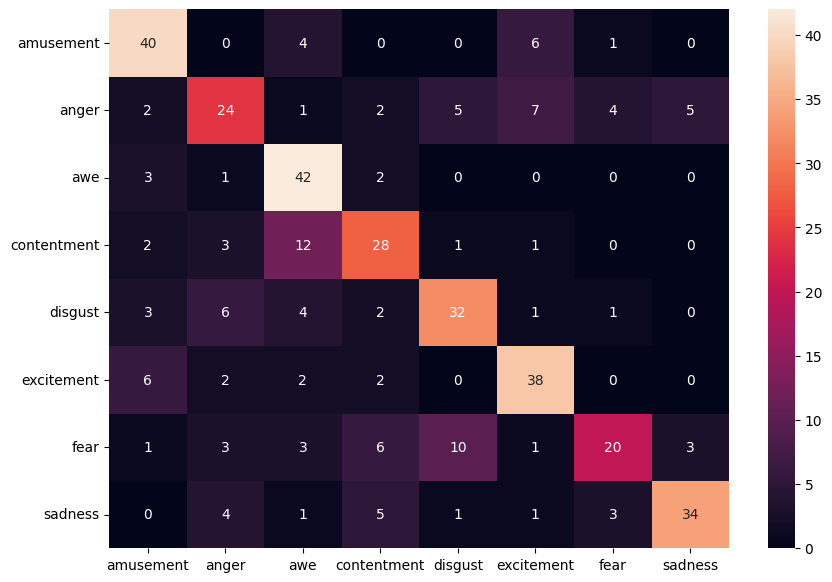

F1 : global 0.6526253071030422, 'amusement' : 0.7407, 'anger' : 0.5161, 'awe' : 0.7179, 'contentment' : 0.5957, 'disgust' : 0.6531, 'excitement' : 0.7238, 'fear' : 0.5263, 'sadness' : 0.7473, 


In [26]:
print_conf_mat_topN(best_model, dataloaders_dict,
               all_labels_names=image_datasets['val'].class_to_idx.keys(),
               topNresults=None, binary_classif=False)

In [ ]:
# To keep my best temp model, I need to put it on Google Drive, otherwise it's lost when I close colab
import shutil
shutil.move('temp_' + name_model, '{}/best_accuracy_{}'.format(data_dir, name_model))

## Preguntas

* Que pienses de la matriz de confusion?
* Porque hace sentido de mirar la accuracy topN?

## Respuestas

* En la matriz de confusión, lo primero que se nota es que, en general, el modelo tiene un buen desempeño, ya que los valores se concentran en la diagonal, lo que indica que clasifica correctamente la mayoría de las veces. Las clases que mejor clasifica son "diversión" (amusement) y "asombro" (awe), mientras que las clases que presentan más dificultades para el modelo son "ira" (anger), "satisfacción" (contentment) y "miedo" (fear). Estas confusiones pueden deberse a que algunas emociones comparten características que el modelo encuentra difíciles de diferenciar.

* Evaluar el accuracy topN tiene sentido, ya que, si el modelo no acierta con la clase correcta en su primera predicción, puede ser útil considerar en qué posición se encuentra la clase correcta entre las N opciones más probables. Esto es especialmente relevante cuando existen clases con una relación más cercana entre sí. Por ejemplo, es comprensible que el modelo pueda confundir "excitación" (excitement) con "diversión" (amusement), ya que son emociones parecidas. Sin embargo, es posible que la predicción correcta se encuentre en la segunda posición, lo que se capturaría al evaluar la precisión topN. 

### Test on our own images !

Funny test

In [22]:
# Load the best_model
best_model = torch.load('{}/fine_tune_total_best_accuracy.pt'.format(data_dir))

def show_predictions(best_model, verbose=False):
    """
    Upload an image and look at the predictions
    """

    # Get the image
    uploaded = files.upload()

    if len(uploaded.keys()) > 1:
      for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
    elif len(uploaded.keys()) == 1:
      fn = list(uploaded.keys())[0]
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    else:
      print('Error: file not uploaded')

    im = Image.open(fn)
    width, height = im.size

    ratio_resize = 500./width # so it becomes "more or less" like an image of the corpus of size 500*390

    # If Resnet, input_size = 224
    input_size = 224

    # Preprocess the image
    img_preproc = transforms.Compose([
            transforms.Resize([int(width*ratio_resize), int(height*ratio_resize)]),
            # transforms.RandomResizedCrop(input_size),
            # transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    img_input = img_preproc(im)

    if verbose: print(img_input.shape)

    # Calculate outputs
    output_resnet = best_model(img_input.unsqueeze(0).cuda())[0]
    preds = torch.nn.functional.softmax(output_resnet, dim=0)

    # Show images and results
    dico_labels = image_datasets['val'].class_to_idx
    str_to_write = "Predictions:\n"

    # to sort them from the most to the least probable
    order_descending = np.argsort([k.cpu().detach().numpy() for k in preds])[::-1]

    list_items = list(dico_labels.items())
    # for label, label_idx in dico_labels.items()[order_descending]:
    for idx_order in order_descending:
          label, label_idx = list_items[idx_order]
          str_to_write += "'{}' : {:.2f}\n".format(label, 100*preds[label_idx])
    print(str_to_write)

    plt.imshow(np.asarray(im))

C:\Users\Daniel\AppData\Local\Temp\ipykernel_4276\775573039.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('{}/fine_tune_total_best_accuracy.pt'

In [ ]:
show_predictions(best_model)

## Preguntas

* Qué es un modelo pre-entrenado? Qué significa fine-tunear un modelo?
* Cuáles son las diferencias principales entre entrenar un modelo desde cero y usar Transfer Learning?
* Que pasa con las curvas de aprentizaje cuando utilizamos representaciones viniendo de un modelo ya pre-entrenado?
* A qué hace referencia Layer Freezing? ¿Cuáles podrían ser las ventajas de hacer esto?
* Cuales son las differencias entre extractar los atributos y fine-tunear la ultima capa o fine-tunear todos los parametros del red? Que pasa con las curvas de apprentizaje?
* Cual es el efecto de la aumentacion de datos? Como se puede ver? Que pasa con las curvas de aprentizaje?

## Respuestas

* Un modelo pre-entrenado como su nombre lo indica es un modelo que fue entrenado con una gran cantidad de datos previamente para cumplir con una tarea más general que luego puede ser usado como base para hacer modelos que cumplan con tareas similares. Esto nos permite no partir desde 0 con pesos aleatorios, sno que aprovechar lo aprendido por este modelo para tareas más generales. Fine-Tunear un modelo se refiere al proceso de tomar un modelo pre-entrenado y ajustar sus parámetros (pesos) para que cumpla con una tarea especifica. AL hacer esto como ya se parte de un modelo previo se demora menos en aprender las características para la tarea especifica.
*  La principal diferencia entre partir con un modelo desde cero y usar Transfer Learning es que al comenzar desde 0 partimos con pesos aleatorios y con un bajo accuracy lo que produce que le tome más tiempo en llegar a los mismos resultados. Por otra parte, con Transfer Learning lo que hacemos es aprovechar un modelo pre-entrenado para que realice una tarea más especifica por lo el entrenamiento es mucho más rápido.
* Al utilizar las representaciones de un modelo pre-entrenado se logra que las curvas de aprendizaje muestren una mejora más rápida que comenzando a entrenar desde cero, por lo que converge en  menos épocas. Esto se debe principalmente a que en las primeras épocas ya se tienen representaciones útiles que luego se ajustaran a la tarea requerida.
* El layer Freezing corresponde a dejar congeladas capas (no modificar el peso de ciertas capas) a la hora de hacer fine-tuning a un modelo, hacer esto nos entrega 2 ventajas principales, primero evita overfiting ya que en las capas congeladas no se modifica la representación de cada neurona de la capa y también como no actualizan estas capas se acelera el proceso de aprendizaje ya que se efectúan menos cálculos. 
* extraer atributos corresponde a utilizar las capas pre-entrenadas y usar la respuesta como input para entrenar un nuevo clasificador, por otro lado al hacer fine-tuning modificamos los pesos de el modelo pre-entrenado, podemos hacer esto para la ultima capa solamente o para todo el modelo. De las 3 formas recién mencionadas para usar un modelo pre-entrenado podemos ver que están ordenadas de la que menos toma el entrenamiento, a la que más se demora, pero a su vez van de la que puede aprender con menor precisión la nueva tarea a la que es más precisa. 
* Con la aumentación de datos se aumenta artificialmente el tamaño del conjunto de datos, ya que se realizan transformaciones (rotaciones, crop, flip) a los datos para aumentar la variabilidad y asi también evitar el overfiting, en las curvas de aprendizaje se puede observar que tienden a subir más lento, pero por otra parte mientras va aprendiendo se maneja mejor la diferencia que hay entre el accuracy del dataset de entrenamiento y de validación, ya que en los experimentos prácticos se observo que sin aumentación el accuracy en test llegaba a ser de 1, mientras que el de validación se quedaba estancado cerca del 0.55.